# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden

Last update - 19 Apr 2021

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
While testing, run US model first to baseline the latest model files. Set `us_run` to **True** For the latest stable model, checkout commit from 2 July 2020. 

For automated calculation run `rtlive-model-za.py`. Github Action `rtlive-model-za.yaml` will run automatically in on Github.

In [2]:
us_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [3]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [4]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [5]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [6]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [7]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [8]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [9]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2021-04-14,20210414,195738.0,85061.0,418185.0,335374.0,63491.0,76559.0,37332.0,65213.0,284606.0,0.0,1561559,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-15,20210415,195762.0,85278.0,418540.0,335488.0,63517.0,76693.0,37500.0,65410.0,284743.0,0.0,1562931,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-16,20210416,195795.0,85496.0,418962.0,335579.0,63544.0,76792.0,37653.0,65589.0,284945.0,0.0,1564355,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-17,20210417,195832.0,85727.0,419305.0,335686.0,63567.0,76927.0,37779.0,65746.0,285111.0,0.0,1565680,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-18,20210418,195850.0,85888.0,419591.0,335743.0,63588.0,77050.0,37939.0,65873.0,285247.0,0.0,1566769,https://www.nicd.ac.za/latest-confirmed-cases-...


In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,cumulative_tests_private,cumulative_tests_public,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,,,
2021-04-14,20210414,10216114.0,5740807.0,4475307.0,1486873.0,NaN,NaN,NaN,53498,NaN,NaN,NaN,NaN,NaN,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-15,20210415,10259664.0,5769740.0,4489924.0,1488060.0,NaN,NaN,NaN,53571,NaN,NaN,NaN,NaN,NaN,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-16,20210416,10291264.0,5786586.0,4504678.0,1488572.0,NaN,NaN,NaN,53663,NaN,NaN,NaN,NaN,NaN,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-17,20210417,10305641.0,5795589.0,4510052.0,1489457.0,NaN,NaN,NaN,53711,NaN,NaN,NaN,NaN,NaN,https://www.nicd.ac.za/latest-confirmed-cases-...
2021-04-18,20210418,10337066.0,5808263.0,4528803.0,1490143.0,NaN,NaN,NaN,53736,NaN,NaN,NaN,NaN,NaN,https://www.nicd.ac.za/latest-confirmed-cases-...


## Cleanup data

In [11]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05          1
2020-03-07          2
2020-03-08          3
2020-03-09          7
2020-03-11         13
               ...   
2021-04-14    1561559
2021-04-15    1562931
2021-04-16    1564355
2021-04-17    1565680
2021-04-18    1566769
Name: cases, Length: 408, dtype: int64

In [12]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2021-04-18 00:00:00'))

In [13]:
idx = pd.date_range(casezero, caselast)

In [14]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11          61.0
2020-02-13          67.0
2020-02-14          71.0
2020-02-19          95.0
2020-02-20         106.0
                 ...    
2021-04-14    10216114.0
2021-04-15    10259664.0
2021-04-16    10291264.0
2021-04-17    10305641.0
2021-04-18    10337066.0
Name: tests, Length: 409, dtype: float64

In [15]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06         200.0
2020-03-07         241.0
2020-03-11         645.0
2020-03-12         848.0
2020-03-13         924.0
                 ...    
2021-04-14    10216114.0
2021-04-15    10259664.0
2021-04-16    10291264.0
2021-04-17    10305641.0
2021-04-18    10337066.0
Name: tests, Length: 400, dtype: float64

In [16]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2021-04-14,1561559.0,10216114.0
2021-04-15,1562931.0,10259664.0
2021-04-16,1564355.0,10291264.0


In [17]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [18]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2021-04-14,1561559.0,10216114.0
2021-04-15,1562931.0,10259664.0
2021-04-16,1564355.0,10291264.0
2021-04-17,1565680.0,10305641.0


In [19]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2021-04-14,1561559.0,10216114.0
2021-04-15,1562931.0,10259664.0
2021-04-16,1564355.0,10291264.0
2021-04-17,1565680.0,10305641.0


In [20]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2021-04-14,1561559.0,10216114.0,1599.0,34971.0
2021-04-15,1562931.0,10259664.0,1372.0,43550.0
2021-04-16,1564355.0,10291264.0,1424.0,31600.0
2021-04-17,1565680.0,10305641.0,1325.0,14377.0


In [21]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2021-04-14,1561559.0,10216114.0,1599.0,34971.0
2021-04-15,1562931.0,10259664.0,1372.0,43550.0
2021-04-16,1564355.0,10291264.0,1424.0,31600.0
2021-04-17,1565680.0,10305641.0,1325.0,14377.0


## Calculate Rt

In [22]:
region = 'Total RSA'

In [23]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 10886 seconds.


## Show results

In [24]:
result = summarize_inference_data(gm.inference_data)

In [25]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-04-09,1.108219,1.103136,0.928644,1.273486,1663.929626,1422.420281,1405.781571,1267.0,30560.0
2021-04-10,1.109368,1.104062,0.910093,1.259375,1700.583290,1435.189573,1478.788289,1285.0,29464.0
2021-04-11,1.111550,1.107728,0.912874,1.285365,1739.095943,1450.209903,1371.737541,931.0,23013.0
2021-04-12,1.113328,1.105371,0.900606,1.290310,1779.508128,1467.433390,1384.450297,655.0,16042.0
2021-04-13,1.111776,1.103797,0.925040,1.336883,1822.395014,1486.787308,1097.633244,847.0,26165.0
2021-04-14,1.113659,1.102210,0.910836,1.316624,1868.150968,1508.201516,1550.368705,1599.0,34971.0
2021-04-15,1.114220,1.105741,0.911066,1.338813,1916.380761,1531.619370,1068.219577,1372.0,43550.0
2021-04-16,1.116817,1.108854,0.881548,1.308300,1967.262873,1557.007985,1527.979359,1424.0,31600.0
2021-04-17,1.117414,1.110556,0.899988,1.335508,2021.422115,1584.343136,3124.943621,1325.0,14377.0


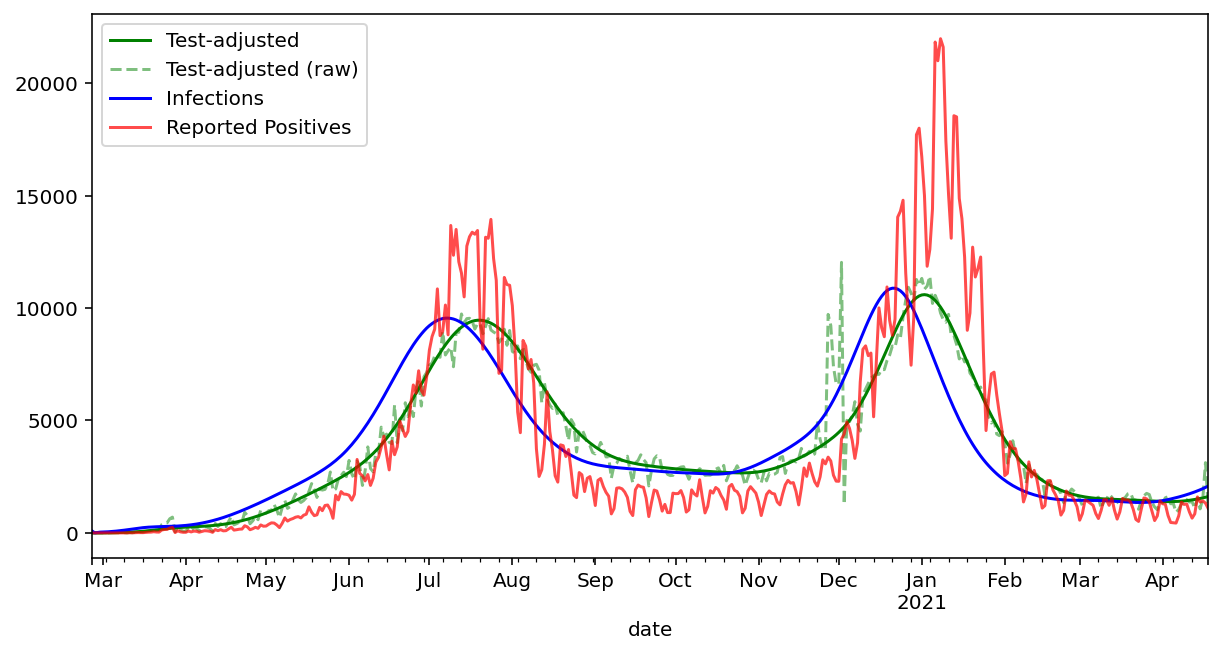

In [26]:
plot_results()

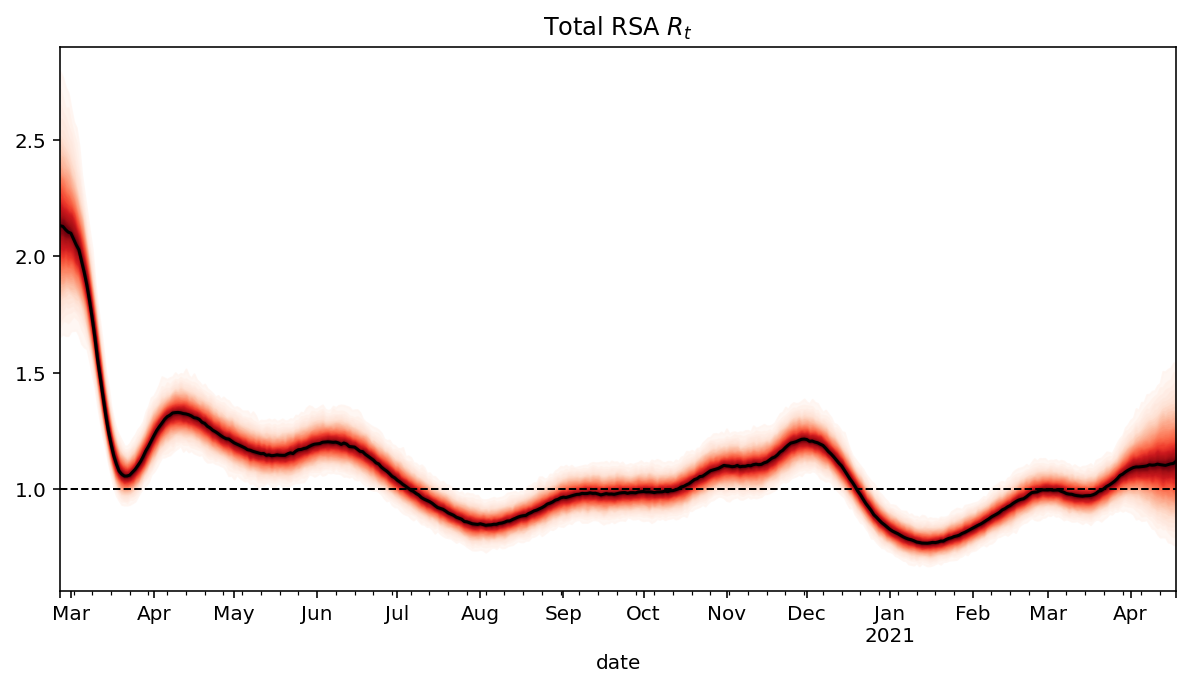

In [27]:
plot_rt()

In [28]:
export_results = result[['median','upper_80','lower_80','infections','test_adjusted_positive']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80','infections':'Infections','test_adjusted_positive':'Adjusted_Postive'})
export_results.tail()

,Median,High_80,Low_80,Infections,Adjusted_Postive
date,,,,,
2021-04-14,1.102210,1.316624,0.910836,1868.150968,1508.201516
2021-04-15,1.105741,1.338813,0.911066,1916.380761,1531.619370
2021-04-16,1.108854,1.308300,0.881548,1967.262873,1557.007985
2021-04-17,1.110556,1.335508,0.899988,2021.422115,1584.343136
2021-04-18,1.120250,1.310090,0.868548,2079.425532,1613.608314


## Export results

In [29]:
export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')